In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

Let's load the parquetfile we saved in notebook 1. You will need to change the filename in the config file!

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-002822-maap-cleaned.parq',
 'current_1': 'whatsapp-20250910-004727-golf-cleaned.parq',
 'current_2': 'whatsapp-20250910-012654-voorganger-golf-cleaned.parq',
 'inputpath': 'whatsapp-20250910-001356-maap.csv',
 'datetime_format': '%d-%m-%Y, %H:%M:%S',
 'drop_authors': []}

In [6]:
root = Path("..").resolve()
processed = root / Path(config["processed"])
datafile_1 = processed / config["current_1"]
if not datafile_1.exists():
    logger.warning(
        f"{datafile_1} does not exist. First run src/preprocess.py, and check the timestamp!"
    )
datafile_2 = processed / config["current_2"]
if not datafile_2.exists():
    logger.warning(
        f"{datafile_2} does not exist. First run src/preprocess.py, and check the timestamp!"
    )


Note how datatypes have been preserved.

In [33]:
df1 = pd.read_parquet(datafile_1)
df2 = pd.read_parquet(datafile_2)
df = pd.concat([df1, df2], ignore_index=True)

# Filter out "Group"
df = df.loc[df["author"] != "Golfmaten"]
df = df.loc[df["author"] != "What's up with golf"]
df = df.loc[df["author"] != "+31 6 46661140"]
df = df.reset_index(drop=True)

df.dtypes

timestamp    datetime64[ns, UTC]
author                    object
message                   object
has_emoji                   bool
dtype: object

In [34]:
df.head()

,timestamp,author,message,has_emoji
0,2020-01-26 16:49:53+00:00,Rob Haasbroek,‎Rob Haasbroek heeft deze groep gemaakt,False
1,2020-01-26 16:49:54+00:00,Rob Haasbroek,‎Rob Haasbroek heeft de groepsafbeelding gewij...,False
2,2020-01-26 16:50:54+00:00,Rob Haasbroek,Jaarlijkse maaltijd om de plannen voor het jaa...,False
3,2020-01-26 16:51:47+00:00,Rob Haasbroek,"Vrijdag 7, 14 of 21 februari?",False
4,2020-01-26 16:52:06+00:00,Rob Haasbroek,Negen of achttien holes vooraf voor de liefheb...,False


Let's count the amount of messages, per author.

In [35]:
p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]

In [36]:
topk_authors = list(topk.index)

In [37]:
df["is_topk"] = df["author"].apply(lambda x: x in topk_authors)
df.head()

,timestamp,author,message,has_emoji,is_topk
0,2020-01-26 16:49:53+00:00,Rob Haasbroek,‎Rob Haasbroek heeft deze groep gemaakt,False,True
1,2020-01-26 16:49:54+00:00,Rob Haasbroek,‎Rob Haasbroek heeft de groepsafbeelding gewij...,False,True
2,2020-01-26 16:50:54+00:00,Rob Haasbroek,Jaarlijkse maaltijd om de plannen voor het jaa...,False,True
3,2020-01-26 16:51:47+00:00,Rob Haasbroek,"Vrijdag 7, 14 of 21 februari?",False,True
4,2020-01-26 16:52:06+00:00,Rob Haasbroek,Negen of achttien holes vooraf voor de liefheb...,False,True


C:\Users\avtnl\AppData\Local\Temp\ipykernel_3708\4020529070.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\avtnl\Documents\HU\Data Analytics\My_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


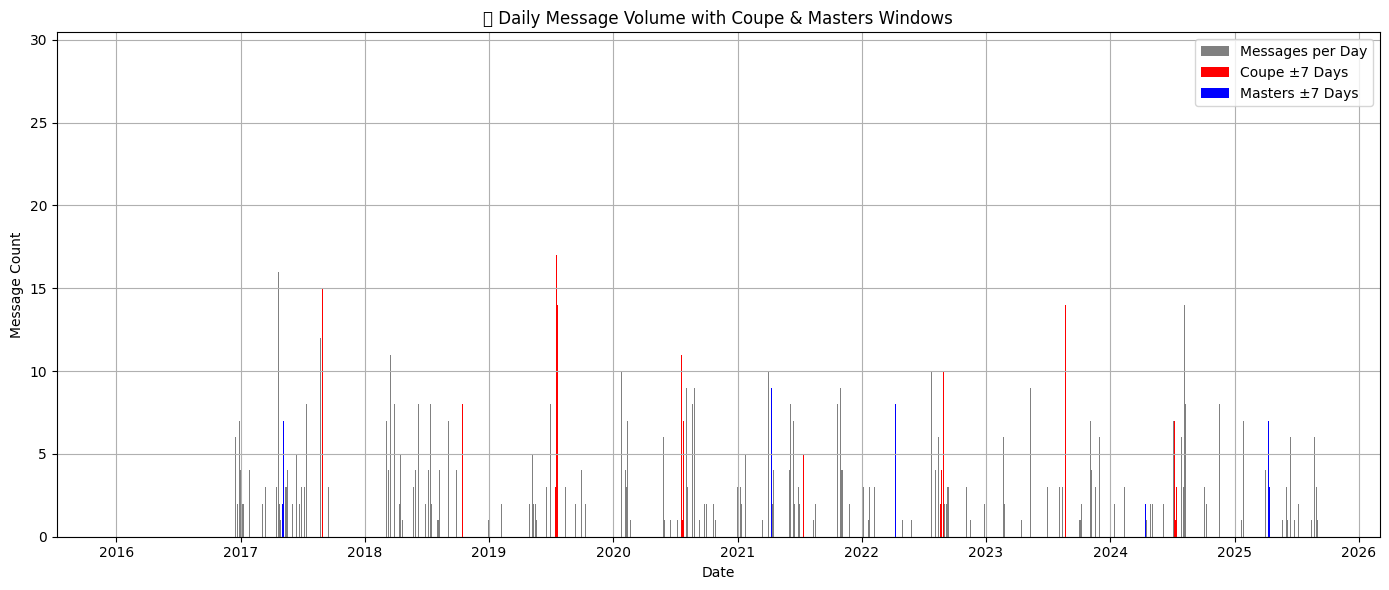

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.date

# Count messages per day
daily_counts = df.groupby("date").size().reset_index(name="message_count")
daily_counts["date"] = pd.to_datetime(daily_counts["date"])  # Convert to datetime for plotting

# Define special dates
dates_coupe = pd.to_datetime([
    "2017-09-03", "2018-10-14", "2019-07-22", "2020-07-26",
    "2021-07-18", "2022-08-28", "2023-08-27", "2024-07-14", "2025-09-14"
])
dates_masters = pd.to_datetime([
    "2017-05-09", "2018-04-08", "2019-04-14", "2020-11-15",
    "2021-04-11", "2022-04-10", "2023-04-09", "2024-04-14", "2025-04-15"
])

# Create sets of dates ±7 before and ±2 after each event
highlight_red = set()
highlight_blue = set()

for date in dates_coupe:
    for offset in range(-7, 3):  # 7 days before to 2 days after
        highlight_red.add(date + pd.Timedelta(days=offset))

for date in dates_masters:
    for offset in range(-7, 3):
        highlight_blue.add(date + pd.Timedelta(days=offset))

# Plot base bar chart
plt.figure(figsize=(14, 6))
plt.bar(daily_counts["date"], daily_counts["message_count"], width=1.0, color="gray", label="Messages per Day")

# Overlay red bars for Coupe windows
red_days = daily_counts[daily_counts["date"].isin(highlight_red)]
plt.bar(red_days["date"], red_days["message_count"], width=1.0, color="red", label="Coupe ±7 Days")

# Overlay blue bars for Masters windows
blue_days = daily_counts[daily_counts["date"].isin(highlight_blue)]
plt.bar(blue_days["date"], blue_days["message_count"], width=1.0, color="blue", label="Masters ±7 Days")

# Customize plot
plt.title("📊 Daily Message Volume with Coupe & Masters Windows")
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

Text(0.5, 1.0, 'Sending the most messages...')

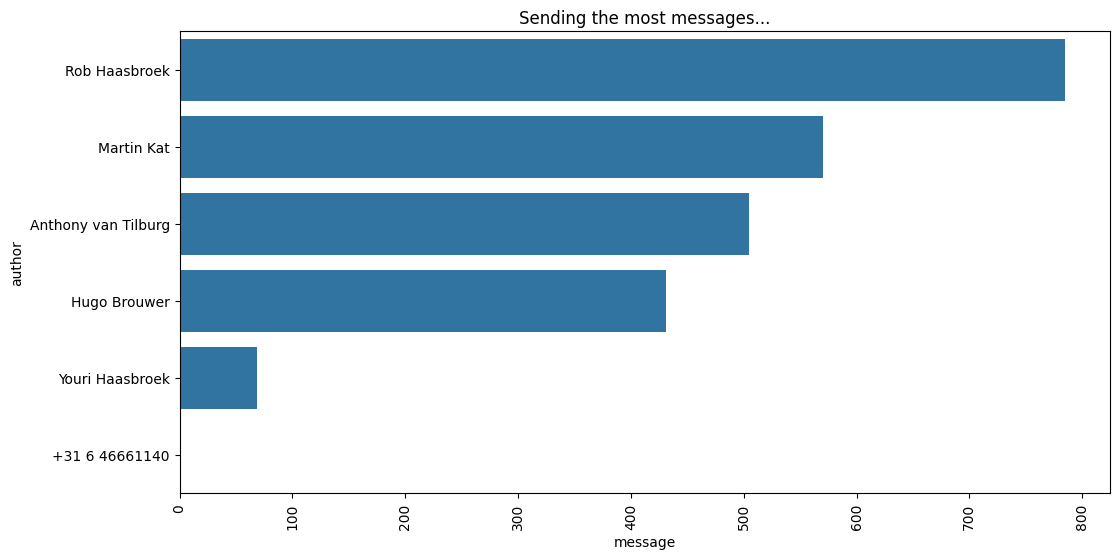

In [38]:
plt.figure(figsize=(12, 6))
sns.barplot(y=p1.index[:k], x="message", data=topk)
plt.xticks(rotation=90)
plt.title("Sending the most messages...")

Maybe tweak the colors a bit

Text(0.5, 1.0, 'Sending the most messages...')

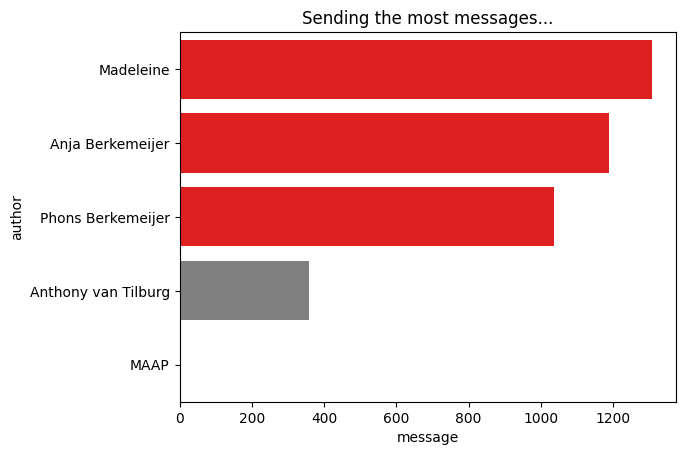

In [10]:
colors = [0 if x < 1000 else 1 for x in topk.message]
custom_palette = {0: "grey", 1: "red"}
sns.barplot(
    y=p1.index[:k],
    x="message",
    hue=colors,
    data=topk,
    palette=custom_palette,
    legend=False,
)
plt.title("Sending the most messages...")

Let's calculate the average message length.

Text(0.5, 1.0, 'Sending the longest messages...')

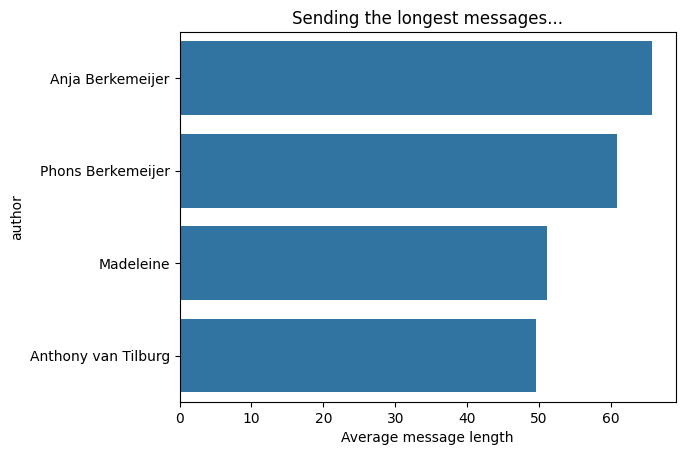

In [12]:
df["message_length"] = df["message"].str.len()

# Exclude author "MAAP"
filtered_df = df[df["author"] != "MAAP"]

# Proceed with the rest of the analysis
p1 = (
    filtered_df[["author", "message_length"]]
    .groupby("author")
    .mean()
    .sort_values("message_length", ascending=False)
)
k = 15
topk = p1[:k]
sns.barplot(y=p1.index[:k], x="message_length", data=topk)
plt.xlabel("Average message length")
plt.title("Sending the longest messages...")

Create a simple regex to look for links in the messages and add that as a feature:

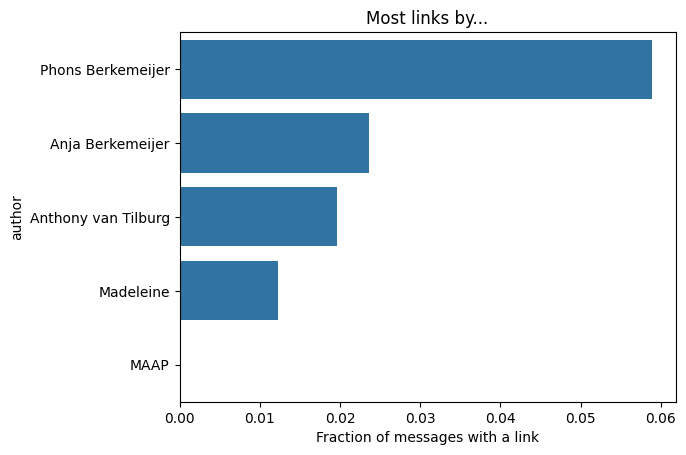

In [13]:
has_link = r"http"
df["has_link"] = df["message"].str.contains(has_link)
if df["has_link"].sum() > 0:
    p1 = (
        df[["author", "has_link"]]
        .groupby("author")
        .mean()
        .sort_values("has_link", ascending=False)
    )

    k = 15
    topk = p1[:k]
    sns.barplot(y=p1.index[:k], x="has_link", data=topk)
    plt.xlabel("Fraction of messages with a link")
    plt.title("Most links by...")
else:
    logger.info("No links found in the messages")

Aggregate the emojis per user (can you change between sum and mean?)

Text(0.5, 1.0, "Are emoji's non-verbal?")

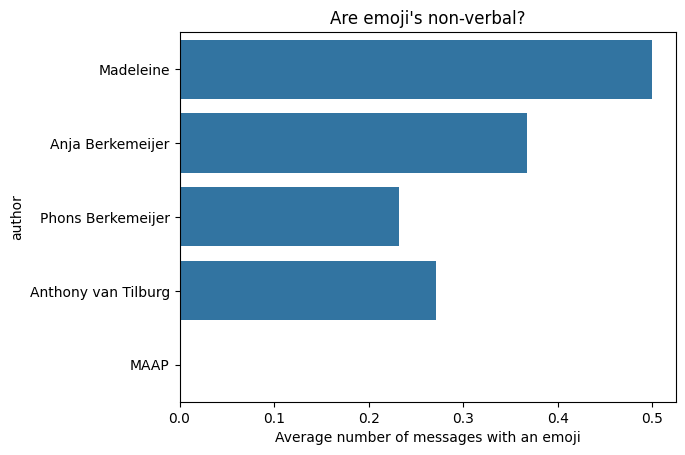

In [14]:
p2 = (
    df[["author", "has_emoji"]]
    .groupby("author")
    .agg(["sum", "mean"])
    .sort_values(("has_emoji", "sum"), ascending=False)
)

p2.columns = p2.columns.droplevel(0)
topk = p2[:k]
sns.barplot(y=p2.index[:k], x="mean", data=topk)
plt.xlabel("Average number of messages with an emoji")
plt.title("Are emoji's non-verbal?")

Let's add a cateory, based on the time when authors send a message:

In [15]:
import pandas as pd

# Define the time ranges
time_ranges = ["00:00", "06:00", "08:00", "17:30", "22:00", "23:59"]
# Define the category labels
categories = ["night", "morning", "worktimes", "evening", "late"]
# Categorize the timestamp column
df["timestamp_category"] = pd.cut(
    df["timestamp"].dt.time.astype(str),
    bins=time_ranges,
    labels=categories,
    right=False,
)
# Display the updated dataframe
df

,timestamp,author,message,has_emoji,is_topk,message_length,has_link,timestamp_category
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False,True,43,False,worktimes
1,2016-11-15 00:34:50+00:00,MAAP,‎Phons Berkemeijer heeft je toegevoegd,False,True,38,False,night
2,2016-11-15 00:35:04+00:00,MAAP,‎Berichten en oproepen worden end-to-end versl...,False,True,893,False,night
3,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True,2972,True,worktimes
4,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True,4997,False,evening
...,...,...,...,...,...,...,...,...
3885,2025-09-04 18:17:57+00:00,Anthony van Tilburg,Alleen moeten we dan voor Anja een zeecontaine...,True,True,57,False,evening
3886,2025-09-04 18:18:05+00:00,Phons Berkemeijer,😂😂,True,True,2,False,evening
3887,2025-09-04 18:19:11+00:00,Anja Berkemeijer,Ik koop daar wel,False,True,16,False,evening
3888,2025-09-04 18:19:23+00:00,Phons Berkemeijer,1 is wel krap dan,False,True,17,False,evening


Now we can group and count the categories:

In [16]:
# Group the dataframe by 'author' and 'timestamp_category', and count the occurrences
p3 = df.groupby(["author", "timestamp_category"]).size().unstack()

# Calculate the fraction of each category for every author
p3_frac = p3.div(p3.sum(axis=1), axis=0)
p3_frac


timestamp_category,night,morning,worktimes,evening,late
author,,,,,
Anja Berkemeijer,0.025274,0.005897,0.500421,0.342881,0.125527
Anthony van Tilburg,0.019608,0.002801,0.456583,0.338936,0.182073
MAAP,1.000000,0.000000,0.000000,0.000000,0.000000
Madeleine,0.028309,0.009946,0.539403,0.316756,0.105585
Phons Berkemeijer,0.034816,0.004836,0.544487,0.307544,0.108317


Let's use plotly the create a stacked bar chart:

In [17]:
p4 = p3_frac.reset_index().melt(id_vars="author")
p4.head()

,author,timestamp_category,value
0,Anja Berkemeijer,night,0.025274
1,Anthony van Tilburg,night,0.019608
2,MAAP,night,1.000000
3,Madeleine,night,0.028309
4,Phons Berkemeijer,night,0.034816


In [18]:
p4_filtered = p4[p4["author"].isin(topk_authors)]

In [22]:
import plotly.express as px

fig = px.bar(
    p4_filtered, y="author", x="value", color="timestamp_category", barmode="stack"
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Let's extract the minimum and maximum time of the messages for every author, and convert that to a decimal fraction:

In [ ]:
df["hour"] = df["timestamp"].dt.time
summary_df = df.groupby("author")["hour"].agg(["min", "max"]).reset_index()


def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour


summary_df["min_x_values"] = summary_df["min"].apply(convert_to_decimal_hours)
summary_df["max_x_values"] = summary_df["max"].apply(convert_to_decimal_hours)

# Drop the original 'min' and 'max' columns as they are no longer needed
summary_df = summary_df.drop(["min", "max"], axis=1)
summary_df.head()

With this, we can create a nice barbell chart. Try to add colors for your own chart!

In [ ]:
# Create a larger plot
plt.figure(figsize=(10, 8))

# Create scatter plots
sns.scatterplot(data=summary_df, x="min_x_values", y="author", color="grey")
sns.scatterplot(data=summary_df, x="max_x_values", y="author", color="grey")

# Add lines
for index, row in summary_df.iterrows():
    plt.plot(
        [row["min_x_values"], row["max_x_values"]],
        [row["author"], row["author"]],
        color="grey",
    )


# Adjust the font size of the y-axis labels if needed
plt.yticks(fontsize=10)

# Show the plot
plt.show()

Another approach for comparing is to create a heatmap:

In [ ]:
df["day_of_week"] = df["timestamp"].dt.dayofweek
author_day_counts = df.groupby(["author", "day_of_week"]).size().unstack(fill_value=0)
author_day_percentages = author_day_counts.div(author_day_counts.sum(axis=1), axis=0)


filtered = author_day_percentages.loc[topk_authors]
sns.heatmap(filtered, annot=True, fmt=".2f", linewidths=0.5, cmap="vlag")
plt.xticks(
    ticks=range(7),
    labels=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    rotation=45,
)
plt.title("Heatmap")

Let's save all the new features we added:

In [ ]:
datafile

In [ ]:
df.to_parquet(datafile, index=False)